# Email Spam Classification



## This Assignment
In this project, you will use what you've learned in class to create a classifier that can distinguish spam (junk or commercial or bulk) emails from ham (non-spam) emails. In addition to providing some skeleton code to fill in, we will evaluate your work based on your model's accuracy and your written responses in this notebook.

After this project, you should feel comfortable with the following:

- Feature engineering with text data
- Using `sklearn` libraries to process data and fit models
- Validating the performance of your model and minimizing overfitting
- Generating and analyzing precision-recall curves

## Warning
This is a **real world** dataset–the emails you are trying to classify are actual spam and legitimate emails. As a result, some of the spam emails may be in poor taste or be considered inappropriate. We think the benefit of working with realistic data outweighs these innapropriate emails, and wanted to give a warning at the beginning of the project so that you are made aware.

## Disclaimer about `sns.distplot()`

This project was designed for a slightly older version of seaborn, which does not support the new `displot` method taught in Lecture 9. Instead, in this project will occasionally call `distplot` (with a `t`). As you may have noticed in several of the previous assignments, use of the `distplot` function triggers a deprecation warning to notify the user that they should replace all deprecated functions with the updated version. Generally, warnings should not be suppressed but we will do so in this assignment to avoid cluttering.

See the seaborn documentation on [distributions](https://seaborn.pydata.org/tutorial/distributions.html) and [functions](https://seaborn.pydata.org/tutorial/function_overview.html) for more details.

In [21]:
# Run this cell to suppress all FutureWarnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Score Breakdown
Question | Points
--- | ---
1a | 1
1b | 1
1c | 2
2 | 3
3a | 2
3b | 2
4 | 2
5 | 2
6a | 1
6b | 1
6c | 2
6d | 2
6e | 1
6f | 3
7 | 6
8 | 6
9 | 3
10 | 15
Total | 55

# Part I - Initial Analysis

In [22]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

### Loading in the Data

In email classification, our goal is to classify emails as spam or not spam (referred to as "ham") using features generated from the text in the email. 

The dataset consists of email messages and their labels (0 for ham, 1 for spam). Your labeled training dataset contains 8348 labeled examples, and the unlabeled test set contains 1000 unlabeled examples. The file containing the labels for the test set is a separate file called `test_label.csv`. 

Run the following cells to load in the data into DataFrames.

The `train` DataFrame contains labeled data that you will use to train your model. It contains four columns:

1. `id`: An identifier for the training example
1. `subject`: The subject of the email
1. `email`: The text of the email
1. `spam`: 1 if the email is spam, 0 if the email is ham (not spam)

The `test` DataFrame contains 1000 unlabeled emails. You will predict labels for these emails and submit your predictions to the autograder for evaluation.

In [23]:
original_training_data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Convert the emails to lower case as a first step to processing the text
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

original_training_data.head()

,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


In [24]:
test.head()

,id,subject,email
0,0,Subject: CERT Advisory CA-2002-21 Vulnerabilit...,\n \n -----begin pgp signed message-----\n \n ...
1,1,Subject: ADV: Affordable Life Insurance ddbfk\n,low-cost term-life insurance!\n save up to 70%...
2,2,Subject: CAREER OPPORTUNITY. WORK FROM HOME\n,------=_nextpart_000_00a0_03e30a1a.b1804b54\n ...
3,3,Subject: Marriage makes both sexes happy\n,"url: http://www.newsisfree.com/click/-3,848315..."
4,4,Subject: Re: [SAtalk] SA very slow (hangs?) on...,on thursday 29 august 2002 16:39 cet mike burg...


### Question 1a
First, let's check if our data contains any missing values. Fill in the cell below to print the number of NaN values in each column. If there are NaN values, replace them with appropriate filler values (i.e., NaN values in the `subject` or `email` columns should be replaced with empty strings). Print the number of NaN values in each column after this modification to verify that there are no NaN values left.

Note that while there are no NaN values in the `spam` column, we should be careful when replacing NaN labels. Doing so without consideration may introduce significant bias into our model when fitting.


In [25]:
print(f"Missing Values in id: {original_training_data['id'].isna().sum()}")
"\n"
print(f"Missing Values in subject: {original_training_data['subject'].isna().sum()}")
"\n"
print(f"Missing Values in email: {original_training_data['email'].isna().sum()}")
"\n"
print(f"Missing Values in spam: {original_training_data['spam'].isna().sum()}")
"\n"
print("There are 6 missing values in the Subject Column")

original_training_data[['subject']] = original_training_data[['subject']].fillna("")

print(f"Missing Values in id: {original_training_data['id'].isna().sum()}")
"\n"
print(f"Missing Values in subject: {original_training_data['subject'].isna().sum()}")
"\n"
print(f"Missing Values in email: {original_training_data['email'].isna().sum()}")
"\n"
print("There are no missing values after the modification")



Missing Values in id: 0
Missing Values in subject: 6
Missing Values in email: 0
Missing Values in spam: 0
There are 6 missing values in the Subject Column
Missing Values in id: 0
Missing Values in subject: 0
Missing Values in email: 0
There are no missing values after the modification


### Question 1b

In the cell below, print the text of the `email` field for the first ham and the first spam email in the original training set.

In [26]:
first_ham = original_training_data.loc[original_training_data['spam'] == 0, 'email'].iloc[0]
first_spam = original_training_data.loc[original_training_data['spam'] == 1, 'email'].iloc[0]
print(f" First ham: {first_ham}")
print(f"First spam: {first_spam}")



 First ham: url: http://boingboing.net/#85534171
 date: not supplied
 
 arts and letters daily, a wonderful and dense blog, has folded up its tent due 
 to the bankruptcy of its parent company. a&l daily will be auctioned off by the 
 receivers. link[1] discuss[2] (_thanks, misha!_)
 
 [1] http://www.aldaily.com/
 [2] http://www.quicktopic.com/boing/h/zlfterjnd6jf
 
 

First spam: <html>
 <head>
 </head>
 <body>
 <font size=3d"4"><b> a man endowed with a 7-8" hammer is simply<br>
  better equipped than a man with a 5-6"hammer. <br>
 <br>would you rather have<br>more than enough to get the job done or fall =
 short. it's totally up<br>to you. our methods are guaranteed to increase y=
 our size by 1-3"<br> <a href=3d"http://209.163.187.47/cgi-bin/index.php?10=
 004">come in here and see how</a>
 </body>
 </html>
 
 
 



### Question 1c

Discuss one thing you notice that is different between the two emails that might relate to the identification of spam.

#### The spam email contains HTML tags like which are often in spam messages and not in ham messages. The ham message has mostly normal text and does not have any HTML formatting

## Training Validation Split
The training data we downloaded is all the data we have available for both training models and **validating** the models that we train.  We therefore need to split the training data into separate training and validation datsets.  You will need this **validation data** to assess the performance of your classifier once you are finished training. **Note that we set the seed (random_state) to 2021**. This will produce a pseudo-random sequence of random numbers that is the same for every student. **Do not modify this in the following questions, as our tests depend on this random seed.**

In [27]:
# This creates a 90/10 train-validation split on our labeled data

from sklearn.model_selection import train_test_split

train, val = train_test_split(original_training_data, test_size=0.1, random_state=2021)

# Basic Feature Engineering

We would like to take the text of an email and predict whether the email is ham or spam. This is a *classification* problem, so we can use logistic regression to train a classifier. Recall that to train an logistic regression model we need a numeric feature matrix $X$ and a vector of corresponding binary labels $y$.  Unfortunately, our data are text, not numbers. To address this, we can create numeric features derived from the email text and use those features for logistic regression.

Each row of $X$ is an email. Each column of $X$ contains one feature for all the emails. We'll guide you through creating a simple feature, and you'll create more interesting ones as you try to increase the accuracy of your model.

### Question 2

Create a function called `words_in_texts` that takes in a list of `words` and a pandas Series of email `texts`. It should output a 2-dimensional NumPy array containing one row for each email text. The row should contain either a 0 or a 1 for each word in the list: 0 if the word doesn't appear in the text and 1 if the word does. For example:

```
>>> words_in_texts(['hello', 'bye', 'world'], 
                   pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])
```

In [28]:
def words_in_texts(words, texts):
    '''
    Args:
        words (list): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    array = []

    for text in texts:
        row = []
        for word in words:
            if word in text:
                row.append(1)
            else:
                row.append(0)
        array.append(row)
    
    indicator_array = np.array(array)
    
    return indicator_array


In [29]:
words_in_texts(['hello', 'bye', 'world'], 
                   pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])

# Basic EDA

We need to identify some features that allow us to distinguish spam emails from ham emails. One idea is to compare the distribution of a single feature in spam emails to the distribution of the same feature in ham emails. If the feature is itself a binary indicator, such as whether a certain word occurs in the text, this amounts to comparing the proportion of spam emails with the word to the proportion of ham emails with the word.

The following plot (which was created using `sns.barplot`) compares the proportion of emails in each class containing a particular set of words. 

![training conditional proportions](training_conditional_proportions.png)

You can use DataFrame's `.melt` method to "unpivot" a DataFrame. See the following code cell for an example.

In [30]:
from IPython.display import display, Markdown
df = pd.DataFrame({
    'word_1': [1, 0, 1, 0],
    'word_2': [0, 1, 0, 1],
    'type': ['spam', 'ham', 'ham', 'ham']
})
display(Markdown("> Our Original DataFrame has a `type` column and some columns corresponding to words. You can think of each row as a sentence, and the value of 1 or 0 indicates the number of occurences of the word in this sentence."))
display(df);
display(Markdown("> `melt` will turn columns into entries in a variable column. Notice how `word_1` and `word_2` become entries in `variable`; their values are stored in the value column."))
display(df.melt("type"))

> Our Original DataFrame has a `type` column and some columns corresponding to words. You can think of each row as a sentence, and the value of 1 or 0 indicates the number of occurences of the word in this sentence.

,word_1,word_2,type
0,1,0,spam
1,0,1,ham
2,1,0,ham
3,0,1,ham


> `melt` will turn columns into entries in a variable column. Notice how `word_1` and `word_2` become entries in `variable`; their values are stored in the value column.

,type,variable,value
0,spam,word_1,1
1,ham,word_1,0
2,ham,word_1,1
3,ham,word_1,0
4,spam,word_2,0
5,ham,word_2,1
6,ham,word_2,0
7,ham,word_2,1


### Question 3a

Create a bar chart like the one above comparing the proportion of spam and ham emails containing certain words. Choose a set of words that are different from the ones above, but also have different proportions for the two classes. Make sure to only consider emails from `train`.

In [31]:
train=train.reset_index(drop=True) # We must do this in order to preserve the ordering of emails to labels for words_in_texts

words_to_check =  ['drug', 'bank', 'prescription', 'memo', 'private']

tag_matrix = words_in_texts(words_to_check, train['email'])

tag_df = pd.DataFrame(tag_matrix, columns=words_to_check)

tag_df['spam'] = train['spam']

tag_df_melted = tag_df.melt(id_vars='spam', var_name='tag', value_name='contains_tag')

display(tag_df_melted)
proportions = tag_df_melted.groupby(['spam', 'tag'])['contains_tag'].mean().reset_index()

display(proportions)


,spam,tag,contains_tag
0,0,drug,0
1,0,drug,0
2,1,drug,0
3,1,drug,0
4,0,drug,0
...,...,...,...
37560,0,private,0
37561,0,private,0
37562,1,private,0
37563,1,private,0


,spam,tag,contains_tag
0,0,bank,0.020718
1,0,drug,0.009645
2,0,memo,0.045008
3,0,prescription,0.001607
4,0,private,0.026790
5,1,bank,0.095611
6,1,drug,0.034483
7,1,memo,0.032393
8,1,prescription,0.024556
9,1,private,0.082550


When the feature is binary, it makes sense to compare its proportions across classes (as in the previous question). Otherwise, if the feature can take on numeric values, we can compare the distributions of these values for different classes. 

### Question 3b

[training conditional densities](training_conditional_densities.png)

Create a *class conditional density plot* like the one above (using `sns.distplot`), comparing the distribution of the length of spam emails to the distribution of the length of ham emails in the training set. Set the x-axis limit from 0 to 50000.

Text(0.5, 1.0, 'Class Conditional Density of Email Lengths')

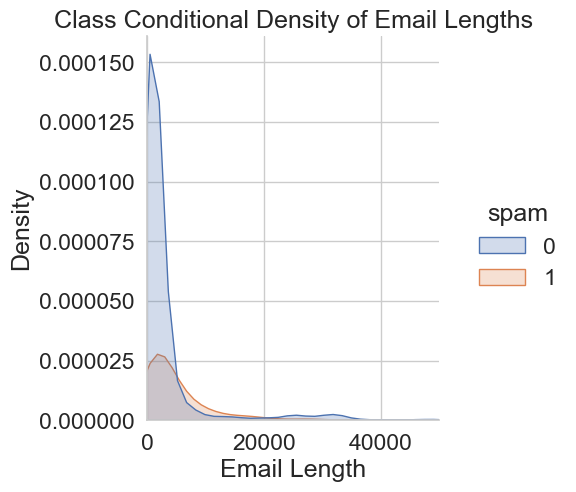

In [32]:

train['email_length'] = train['email'].str.len()

sns.displot(data=train, x="email_length", hue="spam", kind="kde", fill=True)

plt.xlim(0, 50000)
plt.xlabel("Email Length")
plt.ylabel("Density")
plt.title("Class Conditional Density of Email Lengths")



# Basic Classification

Notice that the output of `words_in_texts(words, train['email'])` is a numeric matrix containing features for each email. This means we can use it directly to train a classifier!

### Question 4

We've given you 5 words that might be useful as features to distinguish spam/ham emails. Use these words as well as the `train` DataFrame to create two NumPy arrays: `X_train` and `Y_train`.

`X_train` should be a matrix of 0s and 1s created by using your `words_in_texts` function on all the emails in the training set.

`Y_train` should be a vector of the correct labels for each email in the training set.


In [33]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private'] 

X_train = words_in_texts(some_words, train['email'])
Y_train = train['spam']

X_train[:5], Y_train[:5]

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0]]),
 0    0
 1    0
 2    1
 3    1
 4    0
 Name: spam, dtype: int64)

### Question 5

Now that we have matrices, we can build a model with `scikit-learn`! Using the [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier, train a logistic regression model using `X_train` and `Y_train`. Then, output the model's training accuracy below. You should get an accuracy of around $0.75$

In [34]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, Y_train)

training_accuracy = model.score(X_train, Y_train)
print("Logstic regression training accuracy: ", training_accuracy)

Logstic regression training accuracy:  0.7578863303607081


## Evaluating Classifiers

That doesn't seem too shabby! But the classifier you made above isn't as good as the accuracy would make you believe. First, we are evaluating accuracy on the training set, which may provide a misleading accuracy measure. Accuracy on the training set doesn't always translate to accuracy in the real world (on the test set). In future parts of this analysis, we will hold out some of our data for model validation and comparison.

Presumably, our classifier will be used for **filtering**, i.e. preventing messages labeled `spam` from reaching someone's inbox. There are two kinds of errors we can make:
- False positive (FP): a ham email gets flagged as spam and filtered out of the inbox.
- False negative (FN): a spam email gets mislabeled as ham and ends up in the inbox.

To be clear, we label spam emails as 1 and ham emails as 0. These definitions depend both on the true labels and the predicted labels. False positives and false negatives may be of differing importance, leading us to consider more ways of evaluating a classifier, in addition to overall accuracy:

**Precision** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FP}}$ of emails flagged as spam that are actually spam.

**Recall** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FN}}$ of spam emails that were correctly flagged as spam. 

**False-alarm rate** measures the proportion $\frac{\text{FP}}{\text{FP} + \text{TN}}$ of ham emails that were incorrectly flagged as spam. 

The two graphics below may help you understand precision and recall visually:

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/700px-Precisionrecall.svg.png" width="500px">

Note that a true positive (TP) is a spam email that is classified as spam, and a true negative (TN) is a ham email that is classified as ham.

### Question 6a

Suppose we have a classifier `zero_predictor` that always predicts 0 (never predicts positive). How many false positives and false negatives would this classifier have if it were evaluated on the training set and its results were compared to `Y_train`? Fill in the variables below (feel free to hard code your answers for this part):

In [35]:
zero_predictor_fp = 0
zero_predictor_fn = (Y_train == 1).sum() 
zero_predictor_fp, zero_predictor_fn

(0, np.int64(1914))

### Question 6b

What is the accuracy and recall of `zero_predictor` (classifies every email as ham) on the training set? Do **NOT** use any `sklearn` functions.

In [36]:
zero_predictor_acc = ((Y_train == 0).sum())/(len(Y_train))
zero_predictor_precision = 0
zero_predictor_recall = 0
zero_predictor_far = 0

print(f"Zero predictor accuracy is {zero_predictor_acc}")
print(f"Zero predictor recall is {zero_predictor_recall}")
print(f"Zero predictor precision is {zero_predictor_precision}")
print(f"Zero predictor precision is {zero_predictor_far}")


Zero predictor accuracy is 0.7452415812591509
Zero predictor recall is 0
Zero predictor precision is 0
Zero predictor precision is 0


### Question 6c

Provide brief explanations of the results from 6a and 6b. Why do we observe each of these values (FP, FN, accuracy, recall)?

The zero_predictor always predicts 0, so there are no False Positives because it never predicts 1. False Negatives are the instances where the actual label is 1 but the prediction is 0, meaning the number of False Negatives is the count of 1s in Y_train. We observe the FP and FN because they are used to evaluate how well the model is performing by using them to find the accuracy and recall.

### Question 6d

Compute the precision, recall, and false-alarm rate of the `LogisticRegression` classifier created and trained in Question 5. Do **NOT** use any `sklearn` functions.

In [37]:
predicted = model.predict(X_train)
temp_df = pd.DataFrame()
temp_df['predicted'] = predicted
temp_df['y_train'] = Y_train


logistic_predictor_precision = ((temp_df['predicted'] == 1) & (temp_df['y_train'] == 1)).sum() / (
    ((temp_df['predicted'] == 1) & (temp_df['y_train'] == 1)).sum() + 
    ((temp_df['predicted'] == 1) & (temp_df['y_train'] == 0)).sum()
)

logistic_predictor_recall = ((temp_df['predicted'] == 1) & (temp_df['y_train'] == 1)).sum() / (
    ((temp_df['predicted'] == 1) & (temp_df['y_train'] == 1)).sum() + 
    ((temp_df['predicted'] == 0) & (temp_df['y_train'] == 1)).sum()
)

logistic_predictor_far = ((temp_df['predicted'] == 1) & (temp_df['y_train'] == 0)).sum() / (
    ((temp_df['predicted'] == 1) & (temp_df['y_train'] == 0)).sum() + 
    ((temp_df['predicted'] == 0) & (temp_df['y_train'] == 0)).sum()
)


print(f"Logstic regression precision is: {logistic_predictor_precision}")
print(f"Logstic regression recall is: {logistic_predictor_recall}")
print(f"Logstic regression false positive rate is: {logistic_predictor_far}")



Logstic regression precision is: 0.6417910447761194
Logstic regression recall is: 0.11233019853709508
Logstic regression false positive rate is: 0.02143239864261475


In [38]:
fp = ((temp_df['predicted'] == 1) & (temp_df['y_train'] == 0)).sum()
fn = ((temp_df['predicted'] == 0) & (temp_df['y_train'] == 1)).sum()

print(f"There are {fp} false positives and {fn} false negatives")

There are 120 false positives and 1699 false negatives


In [39]:
Metric = ['Accuracy', 'Precision', 'Recall', 'FPR']
log = [training_accuracy, logistic_predictor_precision, logistic_predictor_recall, logistic_predictor_far]
zero = [zero_predictor_acc, zero_predictor_precision, zero_predictor_recall, zero_predictor_far]

table = pd.DataFrame({
    'Metric': Metric,
    'Logistic': log,
    'Zero': zero
})

display(table)


,Metric,Logistic,Zero
0,Accuracy,0.757886,0.745242
1,Precision,0.641791,0.000000
2,Recall,0.112330,0.000000
3,FPR,0.021432,0.000000


### Question 6e

Are there more false positives or false negatives when using the logistic regression classifier from Question 5?

There are more false negatives wen using the logistic regresison classifier

### Question 6f

1. Our logistic regression classifier got 75.79% prediction accuracy (number of correct predictions / total). How does this compare with predicting 0 for every email?
2. Given the word features we gave you above, name one reason this classifier is performing poorly. Hint: Think about how prevalent these words are in the email set.
3. Which of these two classifiers would you prefer for a spam filter and why? Describe your reasoning and relate it to at least one of the evaluation metrics you have computed so far.

1. When we used the zero classifier to predict 0 for every email, we got a 74.52% accuracy which is close to the prediction accuracy of the regression classifier. 

2. The reason the classifier performed poorly is because the words selected are not strong indicators that an email is spam.

3. I would use the logistic regression classifier because it has a higher training accuracy and provides meaningful metrics like precision, recall, and false positive rate, which are essential for evaluating spam detection performance. The zero classifier, on the other hand, always predicts 'ham' (non-spam) and is incapable of detecting spam emails, resulting in undefined or zero values for precision and recall. 


# Part II - Moving Forward

With this in mind, it is now your task to make the spam filter more accurate. In order to get full credit on the accuracy part of this assignment, you must get at least **88%** accuracy on the test set. To see your accuracy on the test set, you will use your classifier to predict every email in the `test` DataFrame.

Here are some ideas for improving your model:

1. Finding better features based on the email text. Some example features are:
    1. Number of characters in the subject / body
    1. Number of words in the subject / body
    1. Use of punctuation (e.g., how many '!'s were there?)
    1. Number / percentage of capital letters 
    1. Whether the email is a reply to an earlier email or a forwarded email
1. Finding better (and/or more) words to use as features. Which words are the best at distinguishing emails? This requires digging into the email text itself. 
1. Better data processing. For example, many emails contain HTML as well as text. You can consider extracting out the text from the HTML to help you find better words. Or, you can match HTML tags themselves, or even some combination of the two.
1. Model selection. You can adjust parameters of your model (e.g. the regularization parameter) to achieve higher accuracy. Recall that you should use cross-validation to do feature and model selection properly! Otherwise, you will likely overfit to your training data.

You may use whatever method you prefer in order to create features, but **you are not allowed to import any external feature extraction libraries**. In addition, **you are only allowed to train logistic regression models**. No random forests, k-nearest-neighbors, neural nets, etc.

We have not provided any code to do this, so feel free to create as many cells as you need in order to tackle this task. However, answering questions 7, 8, and 9 should help guide you.

---

**Note:** *You may want to use your **validation data** to evaluate your model and get a better sense of how it will perform on the test set.* Note, however, that you may overfit to your validation set if you try to optimize your validation accuracy too much.

---

In [40]:

new_words = [ '<html>', '</html>', '<head>', '</head>', 'onload=', 'charset=', 'content=3d', '<center>', '<tbody>',
              'face=', '</style>', '<style>','colspan=', '</font>', ' </p>', 'bordercolor=', 
             '<body>', '<font size>', '<br>', '<tr>', 'cellspacing=', 'cellpadding=', '<td>', 'bgcolor=', 
             'leftmargin=', 'topmargin=', 'border=', 'urgent', 'limited', 'guarantee', '<meta>', '<button>',
             'marginwidth=', 'marginheight=', 'free', 'winner', 'cash', 'offer', '<form>', '<input>',
             'bgcolor=', '<center>', '</a>', '<p>', ' <x-tab>', 'width=', 'height=', '!!!', '$$$', '???', 
             '<span style=', '<a href=', '100% free', '100% guaranteed']

X_train2 = words_in_texts(new_words, train['email'])
Y_train2 = train['spam']

X_val2 = words_in_texts(new_words, val['email'])  
Y_val2 = val['spam']

new_model = LogisticRegression()
new_model.fit(X_train2, Y_train2)

validation_accuracy = new_model.score(X_val2, Y_val2)

print(f"Validation accuracy is {validation_accuracy}")

Validation accuracy is 0.881437125748503


### Question 7: Feature/Model Selection Process

In this following cell, describe the process of improving your model. You should use at least 2-3 sentences each to address the follow questions:

1. How did you find better features for your model?
2. What did you try that worked or didn't work?
3. What was surprising in your search for good features?

### Question 8: EDA

In the cell below, show a visualization that you used to select features for your model. 

Include:

1. A plot showing something meaningful about the data that helped you during feature selection, model selection, or both.
2. Two or three sentences describing what you plotted and its implications with respect to your features.

Feel free to create as many plots as you want in your process of feature selection, but select only one for the response cell below.

**You should not just produce an identical visualization to question 3.** Specifically, don't show us a bar chart of proportions, or a one-dimensional class-conditional density plot. Any other plot is acceptable, **as long as it comes with thoughtful commentary.** Here are some ideas:

1. Consider the correlation between multiple features (look up correlation plots and `sns.heatmap`). 
1. Try to show redundancy in a group of features (e.g. `body` and `html` might co-occur relatively frequently, or you might be able to design a feature that captures all html tags and compare it to these). 
1. Visualize which words have high or low values for some useful statistic.
1. Visually depict whether spam emails tend to be wordier (in some sense) than ham emails.

Generate your visualization in the cell below and provide your description in a comment.

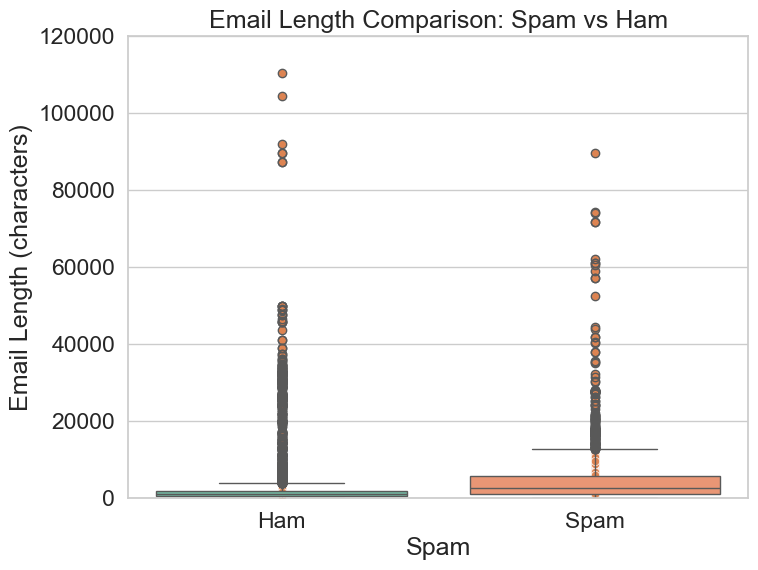

In [41]:
# Write your description (2-3 sentences) as a comment here:
# The boxplot compares the lengths of emails (measured in number of characters) between spam and ham (non-spam) emails. 
# The plot reveals that spam emails tend to have a wider range of lengths, with some being much longer than ham emails. 
# This suggests that email length could be a useful feature for distinguishing between spam and ham emails, as spam emails often exhibit more variability in length.

# Write the code to generate your visualization here:

train['email_length'] = train['email'].apply(len)
val['email_length'] = val['email'].apply(len)

plt.figure(figsize=(8, 6))
sns.boxplot(data=train, x='spam', y='email_length', palette="Set2")
sns.scatterplot(data=train,  x='spam', y='email_length')
plt.title('Email Length Comparison: Spam vs Ham')
plt.xlabel('Spam')
plt.ylim(0, 120000) 
plt.ylabel('Email Length (characters)')
plt.xticks([0, 1], ['Ham', 'Spam'])
plt.show()

### Question 9: ROC Curve

In most cases we won't be able to get 0 false positives and 0 false negatives, so we have to compromise. For example, in the case of cancer screenings, false negatives are comparatively worse than false positives — a false negative means that a patient might not discover that they have cancer until it's too late, whereas a patient can just receive another screening for a false positive.

Recall that logistic regression calculates the probability that an example belongs to a certain class. Then, to classify an example we say that an email is spam if our classifier gives it $\ge 0.5$ probability of being spam. However, *we can adjust that cutoff*: we can say that an email is spam only if our classifier gives it $\ge 0.7$ probability of being spam, for example. This is how we can trade off false positives and false negatives.

The ROC curve shows this trade off for each possible cutoff probability. In the cell below, plot a ROC curve for your final classifier on the training data. Refer to [Section 17.7](https://www.textbook.ds100.org/ch/17/classification_sensitivity_specificity.html) of the course text to see how to plot an ROC curve.

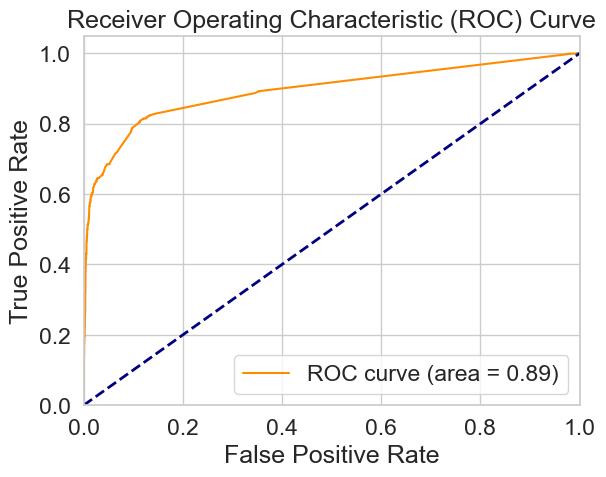

In [42]:
from sklearn.metrics import roc_curve, auc

y_train_prob = new_model.predict_proba(X_train2)[:, 1]

fpr, tpr, _ = roc_curve(Y_train2, y_train_prob)
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, color='darkorange',  label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')




# Question 10: Test Predictions

The following code will write your predictions on the test dataset to a CSV file. 

Save your predictions in a 1-dimensional array called `test_predictions`. **Please make sure you've saved your predictions to `test_predictions` as this is how part of your score for this question will be determined.**

Remember that if you've performed transformations or featurization on the training data, you must also perform the same transformations on the test data in order to make predictions. For example, if you've created features for the words "drug" and "money" on the training data, you must also extract the same features in order to use scikit-learn's `.predict(...)` method.


In [43]:
X_test = words_in_texts(new_words, test['email'])
test_predictions = new_model.predict(X_test)



The following cell generates a CSV file with your predictions. **You must submit this CSV file to the "Project Predictions" dropbox folder in MyLS to get credit for this question.**

In [44]:
from datetime import datetime


# Assuming that your predictions on the test set are stored in a 1-dimensional array called test_predictions

# Construct and save the submission:
submission_df = pd.DataFrame({
    "Id": test['id'], 
    "Class": test_predictions,
}, columns=['Id', 'Class'])
timestamp = datetime.isoformat(datetime.now()).split(".")[0].replace(":", "-")
submission_df.to_csv("submission_{}.csv".format(timestamp), index=False)

print('Created a CSV file: {}.'.format("submission_{}.csv".format(timestamp)))
print('You may now upload this CSV file to dropbox for scoring.')


Created a CSV file: submission_2025-04-04T18-46-22.csv.
You may now upload this CSV file to dropbox for scoring.


## Submission

Make sure you have run all cells in your notebook, so that all images/graphs appear in the output. **Please save before exporting!**